In [ ]:
# This code performs document clustering on news articles, using TF-IDF vectorization, dimensionality reduction with LSA, and KMeans clustering to group similar articles together.
# The 20 newsgroups dataset is fetched based on 3 specified categories, removing unnecessary parts like headers, footers, and quotes.
# TF-IDF vectorization is then performed on the text data to represent each document as a numerical feature vector, utilizing the TfidfVectorizer. 
# The code computes the sparsity of the TF-IDF matrix, quantifying the ratio of non-zero elements to the total number of elements.
# Latent Semantic Analysis (LSA) is applied next to reduce the dimensionality of the TF-IDF matrix while preserving the most important information. 
# The code calculates the explained variance of the Singular Value Decomposition (SVD) step in LSA.
# A KMeans clustering algorithm is then fitted on the LSA-transformed data to group similar documents into clusters, which are visualized in a 3D plot.
# The top terms associated with each cluster are printed, in order to provide insight into the content of the clusters.


# This clustering system was developed by Mihai Eva-Elena and Serban Eva-Maria, as a project for the Numerical Methods course at the Politehnica University of Bucharest.

In [13]:
from collections import defaultdict
from time import time
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from scipy.linalg import svd

from mpl_toolkits.mplot3d import Axes3D


In [14]:
#newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# print("Newsgroup Categories:")
# print(newsgroups.target_names)

# print("\nContents of the First Document:")
# print(newsgroups.data[0])

# print("\nTarget Label of the First Document:")
# print(newsgroups.target[0])

In [15]:
categories = [
    "talk.politics.misc",
    "sci.space",
    "rec.sport.baseball",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")


2756 documents - 3 categories


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.2,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.239 s
n_samples: 2756, n_features: 6683


In [17]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}") #quantifies the sparsity of the matrix

0.008


In [18]:
#for seed in range(5):
# kmeans = KMeans(
#     n_clusters=true_k,
#     max_iter=100,
#     n_init = 1,
#     random_state=42,
# ).fit(X_tfidf)
# cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
# print(f"Number of elements assigned to each cluster: {cluster_sizes}")
# print()
# print(
#     "True number of documents in each category according to the class labels: "
#     f"{category_sizes}"
# )

In [19]:
#u, s, vt = svd(X_tfidf.toarray())

In [20]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.322 s
Explained variance of the SVD step: 19.1%


In [25]:
print(X_lsa.shape)

(2756, 100)


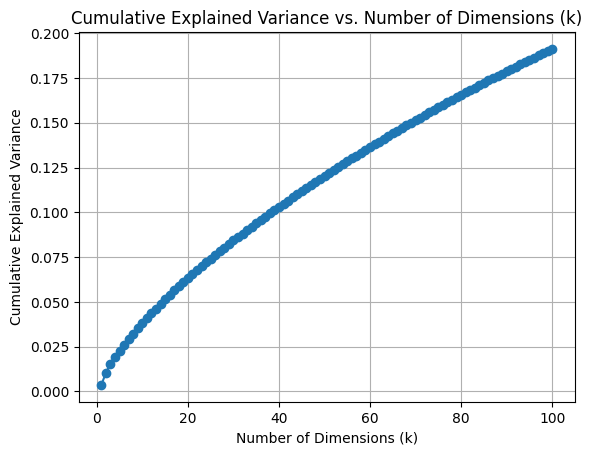

In [21]:
singular_values = lsa[0].singular_values_

explained_variance_ratio = lsa[0].explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(singular_values) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance vs. Number of Dimensions (k)')
plt.xlabel('Number of Dimensions (k)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [22]:
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init = 1,
        random_state=seed,
    ).fit(X_lsa)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [ 581 1455  720]
Number of elements assigned to each cluster: [1505  574  677]
Number of elements assigned to each cluster: [ 772 1290  694]
Number of elements assigned to each cluster: [1216  770  770]
Number of elements assigned to each cluster: [ 601 1431  724]

True number of documents in each category according to the class labels: [994 987 775]


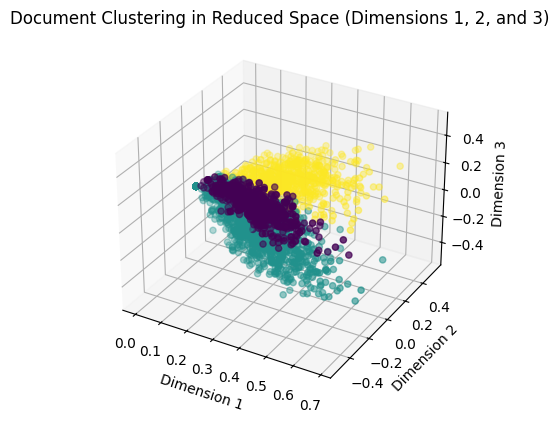

In [23]:

clusters = kmeans.fit_predict(X_lsa)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_lsa[:, 0], X_lsa[:, 1], X_lsa[:, 2], c=clusters, cmap='viridis')
ax.set_title('Document Clustering in Reduced Space (Dimensions 1, 2, and 3)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

In [24]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i + 1}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 1: space orbit launch nasa shuttle earth moon mission satellite solar 
Cluster 2: people know government did right make time want does new 
Cluster 3: game year team games baseball hit good players runs season 
